# Tutorial: Interactive Maps with Python, Part 3
## Animated maps

In this final chapter of our 3-part series, we will set our data in motion. While folium has the capability of showing videos in a browser, we will only export our animations to separate video files (that you can then upload to youtube, etc.)

Let's start with some prerequisites. You'll need to install the selenium package for python:
```
pip install selenium
```

**Update Nov 2018:** selenium has depricated phantomjs so we will use headless firefox as a driver instead. This means we need to pull the latest version of folium from github as well:

```
pip install --upgrade git+https://github.com/python-visualization/folium
```

and you'll need to install ~~phantom.js~~ geckodriver and ffmpeg on your system path.
you can download them here:

https://github.com/mozilla/geckodriver/releases/

and here:

https://ffmpeg.org/

In [1]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import pandas as pd
import folium
from folium import plugins
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap, rgb_to_hsv, hsv_to_rgb
import scipy.ndimage.filters
import time
import datetime
import os.path
import io

import os
os.environ["PATH"] += os.pathsep + "."

%matplotlib inline

We wrote a lot of code in the previous tutorials. I moved some of those functions to a separate file called consolidated_functions. We import it here as 'cf'.

In [2]:
import consolidated_functions as cf

And we load our data as usual.

In [3]:
bike_data = pd.read_csv("201610-citibike-tripdata.csv")
bike_data["Start Time"] = pd.to_datetime(bike_data["Start Time"])
bike_data["Stop Time"] = pd.to_datetime(bike_data["Stop Time"])
bike_data["hour"] = bike_data["Start Time"].map(lambda x: x.hour)


## Net arrivals
The first challenge we run into is that we want to generate movies that vary smoothly in time. This means that we have to generate a sufficiently large number of frames over the (real-world) Time span that we want to visualize. Option one is to aggregate the bike data into smaller time intervals, say, every minute. The problem with that approach is that there is a loss of variation in the number of arrivals at each station from minute to minute.

Therefore, we will take a different approach: we will still aggregate by hour but we will interpolate values for intermediate times.

In [4]:
def interpolate(df1, df2, x):
    """return a weighted average of two dataframes"""
    df = df1 * (1 - x) + df2 * x
    return df.replace(np.nan, 0)


def get_trip_counts_by_minute(float_hour, data):
    """get an interpolated dataframe for any time, based
    on hourly data"""
    
    columns = ["Start Station Latitude",
               "Start Station Longitude",
               "Departure Count",
               "Arrival Count"]
    df1 = cf.get_trip_counts_by_hour(int(float_hour), data)
    df2 = cf.get_trip_counts_by_hour(int(float_hour) + 1, data)
    
    df = interpolate(df1.loc[:,columns], 
                     df2.loc[:,columns], 
                     float_hour % 1)
    
    df["Start Station Name"] = df1["Start Station Name"]
    return df

We can now generate a map corresponding to a desired time of day (specified as a float). Here is an example:

In [5]:
cf.plot_station_counts(get_trip_counts_by_minute(9.5, bike_data), zoom_start=14)

We want to create many of these maps in a loop for different times of day. To do that, we need to write a function that takes some settings an input and saves one frame of the movie as an image file.

In [6]:
def go_arrivals_frame(i, hour_of_day, save_path):
    
    # create the map object
    data = get_trip_counts_by_minute(hour_of_day, bike_data)
    my_frame = cf.plot_station_counts(data, zoom_start = 14)
    
    # generate the png file as a byte array
    png = my_frame._to_png()
    
    #  now add a caption to the image to indicate the time-of-day.
    hour = int(hour_of_day)
    minutes = int((hour_of_day % 1) * 60)
    
    # create a PIL image object
    image = Image.open(io.BytesIO(png))
    draw = ImageDraw.ImageDraw(image)
    
    # load a font
    font = ImageFont.truetype("Roboto-Light.ttf", 30)
    
    # draw time of day text
    draw.text((20,image.height - 50), 
              "time: {:0>2}:{:0>2}h".format(hour, minutes),
              fill=(255, 255, 255), 
              font=font)
    
    # draw title
    draw.text((image.width - 400,20), 
              "Net Arrivals vs Time of Day",
              fill=(255, 255, 255), 
              font=font)
    
    # write to a png file
    filename = os.path.join(save_path, "frame_{:0>5}.png".format(i))
    image.save(filename, "PNG")
    return image

Next, we generate a sequence of these frames that we can stitch together into a movie.
We can then call our function in a loop to generate many frames. 

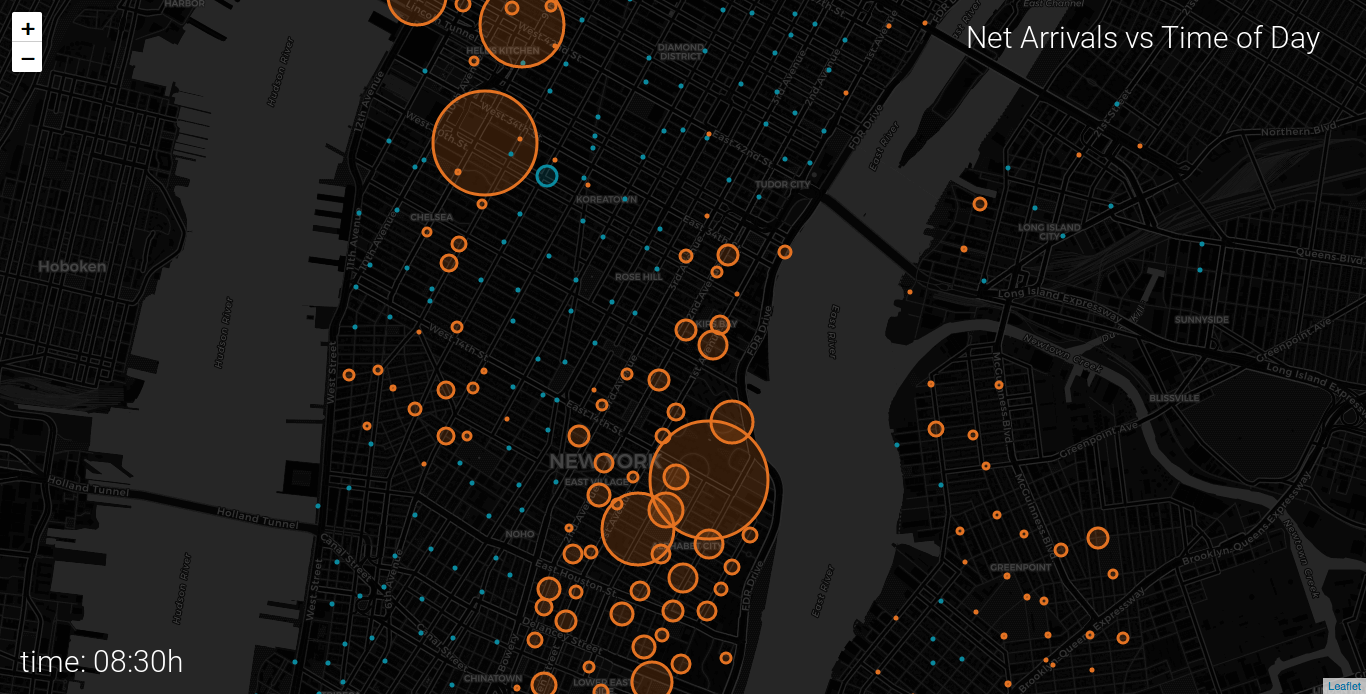

In [7]:
dir_name = 'frames'
if not os.path.exists(dir_name):
    os.mkdir(dir_name)
go_arrivals_frame(1, 8.5, dir_name)

In [8]:
arrival_times = np.arange(6, 23, .2)
for i, hour in enumerate(arrival_times):
    go_arrivals_frame(i, hour, "frames")

We can convert the resulting images into a movie using ffmpeg (or your favorite video editing program). We will do this from the command line like this:
```
ffmpeg -r 10 -i frames/frame_%05d.png -c:v libx264 -vf fps=25 -crf 17 -pix_fmt yuv420p output.mp4
```

## Individual Trips
We can now do the same for the individual trips we worked with in part 2. We'll draw the current location of a trip as a glowing dot and draw the path from its origin as glowing (but fainter) line. First we need to do some data pre-processing:

In [9]:
def get_path_progress(trips, image_time):
    """ return a series of numbers between 0 and 1 
    indicating the progress of each trip at the given time"""
    
    trip_duration = trips["Stop Time"] - trips["Start Time"]
    path_progress = (image_time - trips["Start Time"]).dt.total_seconds() / trip_duration.dt.total_seconds()
    return path_progress

def get_current_position(trips, progress):
    """ Return Latitude and Longitude for the 'current position' of each trip.
    Paths are assumed to be straight lines between start and end. 
    """
    
    current_latitude = trips["Start Station Latitude"]*(1- progress) + \
                       trips["End Station Latitude"]* progress
    current_longitude = trips["Start Station Longitude"]*(1- progress) + \
                       trips["End Station Longitude"]* progress
    return current_latitude, current_longitude


def get_active_trips(image_time, bike_data, image_shape, line_len = .1):
    """ Return pixel coordinates only for trips that have started and 
    not yet completed for the given time.
    """
    
    bounds = cf.get_min_max(bike_data)
    
    active_trips = bike_data[(bike_data["Start Time"]<=image_time)]
    active_trips = active_trips[(active_trips["Stop Time"]>=image_time)].copy()
    
    progress = get_path_progress(active_trips, image_time)
    
    current_latitude, current_longitude = get_current_position(active_trips, progress)
    start_latitude, start_longitude = get_current_position(active_trips, np.clip(progress-line_len, 0, 1))
    
    start_y, start_x = cf.latlon_to_pixel(start_latitude, 
                                          start_longitude, 
                                          image_shape,
                                          bounds)
    
    end_y, end_x = cf.latlon_to_pixel(current_latitude, 
                                      current_longitude, 
                                      image_shape,
                                      bounds)
    xys = list(zip(start_x, start_y, end_x, end_y))
    weights = np.clip((1 - progress.values)*100, 0, 1)
    
    return xys, weights
    

As before, we have to convert latitude and longitude to pixel coordinates. We do this with the help of some of the functions we developed in part 2. Note how we changed the function signature (the arguments) a little bit to be able to pass some more parameters.

In [10]:
def row_to_pixel(row, image_shape, bounds):
    """
    convert a row (1 trip) to pixel coordinates
    of start and end point
    """
    start_y, start_x = cf.latlon_to_pixel(row["Start Latitude"], 
                                          row["Start Longitude"], 
                                          image_shape,
                                          bounds)
    end_y, end_x = cf.latlon_to_pixel(row["End Latitude"], 
                                      row["End Longitude"], 
                                      image_shape,
                                      bounds)
    xy = (start_x, start_y, end_x, end_y)
    return xy

Finally, we write a function that generates a folilum map with all the elements that we want. 

In [11]:
def get_image_map(frame_time, bike_data):
    """Create the folium map for the given time"""
    
    image_data = np.zeros((900*2,400*2))
    bounds = cf.get_min_max(bike_data)
    
    # plot the current locations
    xys, weights = get_active_trips(frame_time, bike_data, image_data.shape, line_len=.01)
    image_data = cf.add_lines(image_data, xys, weights=weights*20, width = 4)
    
    #  plot the paths
    xys, weights = get_active_trips(frame_time, bike_data, image_data.shape, line_len=1)
    image_data = cf.add_lines(image_data, xys, weights=weights*10, width = 2)
    
    # generate and return the folium map.
    return cf.create_image_map(image_data, bounds)

In [12]:
def create_image_map(image_data, bounds):
    min_lat, max_lat, min_lon, max_lon = bounds
    folium_map = folium.Map(location=[40.738, -73.98],
                            zoom_start=13,
                            tiles="CartoDB dark_matter",
                            width='100%')

    # create the overlay
    map_overlay = cf.add_alpha(cf.to_image(image_data))

    # compute extent of image in lat/lon
    aspect_ratio = map_overlay.shape[1]/map_overlay.shape[0]
    delta_lat = (max_lon-min_lon)/aspect_ratio*np.cos(min_lat/360*2*np.pi)

    # add the image to the map
    img = folium.raster_layers.ImageOverlay(map_overlay,
                               bounds = [(max_lat-delta_lat,min_lon),(max_lat,max_lon)],
                               opacity = 1,
                               name = "Paths")

    img.add_to(folium_map)
    folium.LayerControl().add_to(folium_map)

    # return the map
    return folium_map

In [13]:
get_image_map(pd.to_datetime('2016-10-05 09:00:00'), bike_data)

As we did above with net arrivals, we now write a function that generates one frame.  

In [14]:
def go_paths_frame(params):
    """Similar to go_arrivals_frame.
    Generate the image, add annotations, and save image file."""
    i, frame_time = params
    
    my_frame = get_image_map(frame_time, bike_data)
    png = my_frame._to_png()
    
    image = Image.open(io.BytesIO(png))
    draw = ImageDraw.ImageDraw(image)
    font = ImageFont.truetype("Roboto-Light.ttf", 30)
    
    # add date and time of day text
    draw.text((20,image.height - 50), 
              "time: {}".format(frame_time),
              fill=(255, 255, 255), 
              font=font)
    
    # draw title
    draw.text((image.width - 450,20), 
              "Paths of Individual Bike Trips",
              fill=(255, 255, 255), 
              font=font)
    
    # write to a png file
    dir_name = "path_frames"
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    image.save(os.path.join(dir_name, "frame_{:0>5}.png".format(i)), "PNG")
    return image

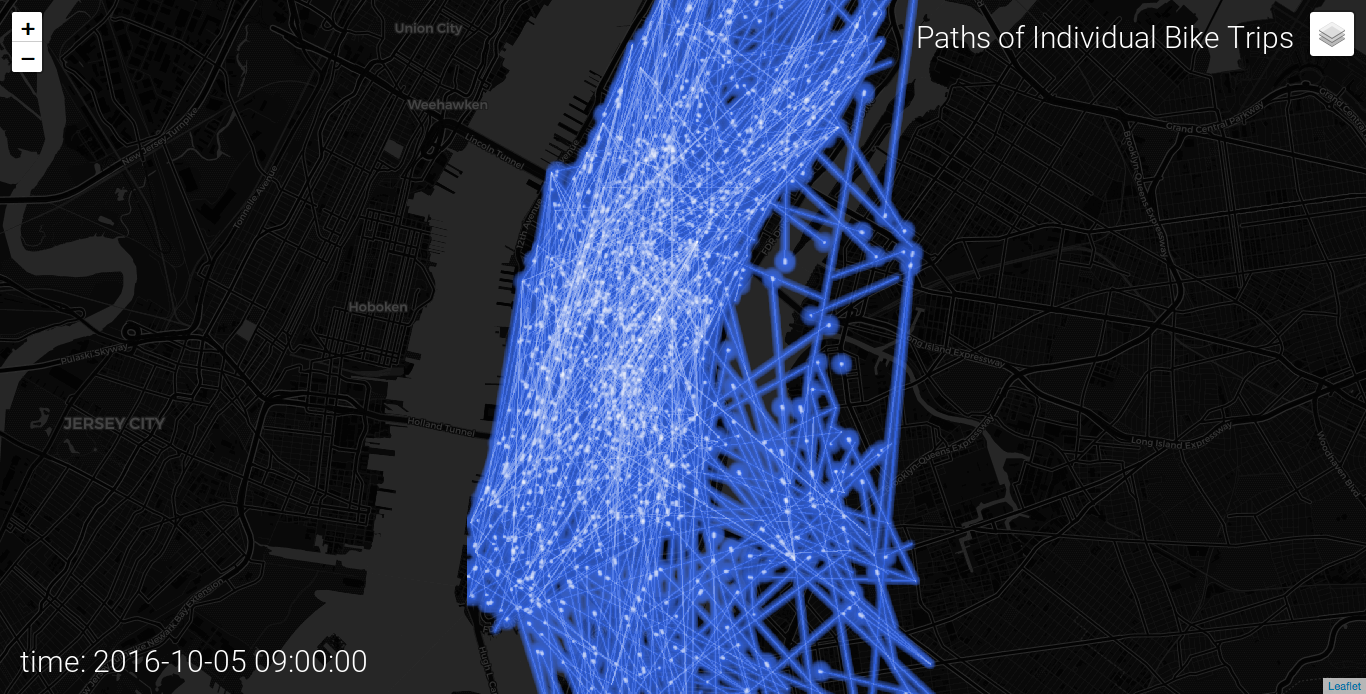

In [15]:
# an example output.
go_paths_frame((1, pd.to_datetime('2016-10-05 09:00:00')))

And now we generate all the frames for the time period we are interested in.

In [16]:
start_time = pd.to_datetime('2016-10-05 09:00:00')
frame_times = [(i, start_time + datetime.timedelta(seconds=30*i)) for i in range(int(120))]

t0 = time.time()
list(map(go_paths_frame,frame_times))
print("time elapsed: {}".format(time.time()-t0))

time elapsed: 4317.150446653366


## Make frames for Title Gif
For the header of the totorial article, we want to use an animation that will play automatically in most browsers. We also want it to look smooth, so we will make a GIF with frames that first move forward in time and then backwards.

In [17]:
hours = list(np.arange(6, 10, .2))
hours = hours + hours[::-1]
dir_name = 'gif_frames'
if not os.path.exists(dir_name):
    os.mkdir(dir_name)
for i, hour in enumerate(hours):
    go_arrivals_frame(i, hour, dir_name)

to generate the gif, use ffmpeg. First create a palette:
```
ffmpeg -y  -t 3 -i frames/frame_%05d.png \
-vf fps=10,scale=320:-1:flags=lanczos,palettegen palette.png
```
then generate the movie:
```
ffmpeg -r 10  -i gif_frames/frame_%05d.png -i palette.png -filter_complex \
"fps=10,scale=720:-1:flags=lanczos[x];[x][1:v]paletteuse" header.gif
```

### regenerate some bad frames

In [18]:
arrival_times = np.arange(6, 23, .2)
frames_to_redo = [27, 41, 74]
for i in frames_to_redo:
    hour = arrival_times[i]
    go_arrivals_frame(i, hour, "frames")

In [19]:
frames_to_redo = [61]
for frame in frames_to_redo:
    go_paths_frame(frame_times[frame])